# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [1]:
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [34]:

def authenticate_user(username: str, password: str) -> bool: 
    """ authenticate_user tool returns True if user exists 
    else returns Flase
    Args: 
        username: str
        password: str
    Retuns : 
        boolean either True or False 
    """
    if username == "Mohammed" and password == "123": 
        return True
    return False

def get_user_info(name: str) -> str: 
    """get_user_info returns int the age of user
    Args: 
        name : str
    Returns: 
        info about the user
    """

    if name == "Mohammed": 
        return "your a SWE and your age is 50"
    return "Invalid user"

In [45]:
tools = [authenticate_user,get_user_info]
groq = ChatGroq(model="llama3-groq-8b-8192-tool-use-preview").bind_tools(tools=tools)

In [35]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="your a helpful assistants the mangages authenticating users for me")

def planner(state: MessagesState): 
    return {"messages": [groq.invoke([sys_msg] + state["messages"])]}

In [12]:
builder = StateGraph(MessagesState)
builder.add_node("planner",planner)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"planner")
builder.add_edge("tools","planner")
builder.add_conditional_edges("planner",tools_condition)

workflow = builder.compile()

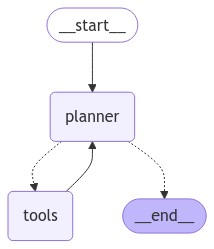

In [13]:
from IPython.display import display, Image

display(Image(workflow.get_graph().draw_mermaid_png()))

In [36]:
from langchain_core.messages import HumanMessage

message = HumanMessage(content="authenticate user Mohammed with password 123")
config = {"configurable": {"thread_id": "1"}}
chat = workflow.invoke({"messages": "authenticate user Mohammed with password 123"})

In [38]:
for m in chat['messages']: 
    m.pretty_print()

================================ Human Message =================================

authenticate user Mohammed with password 123
================================== Ai Message ==================================
Tool Calls:
  authenticate_user (call_nx2n)
 Call ID: call_nx2n
  Args:
    username: Mohammed
    password: 123
================================= Tool Message =================================
Name: authenticate_user

true
================================== Ai Message ==================================

The user Mohammed has been successfully authenticated.


In [41]:
from langgraph.checkpoint.memory import MemorySaver

workflow2 = builder.compile(MemorySaver())
config = {"configurable": {"thread_id": "1"}}
mess = [HumanMessage(content="only tell me if user is authenticated or not user is Mohammed with password 123")]

In [42]:
workflow2.invoke({"messages":message},config)

{'messages': [HumanMessage(content='authenticate user Mohammed with password 123', additional_kwargs={}, response_metadata={}, id='cc739f43-cd2a-4350-99cf-c5995a346776'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yv3n', 'function': {'arguments': '{"username": "Mohammed", "password": "123"}', 'name': 'authenticate_user'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 333, 'total_tokens': 366, 'completion_time': 0.02988461, 'prompt_time': 0.045624288, 'queue_time': 0.0014994220000000003, 'total_time': 0.075508898}, 'model_name': 'llama3-groq-8b-8192-tool-use-preview', 'system_fingerprint': 'fp_260dc69250', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0529e056-2b5d-43fa-8594-b0bde258d9c0-0', tool_calls=[{'name': 'authenticate_user', 'args': {'username': 'Mohammed', 'password': '123'}, 'id': 'call_yv3n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 333, 'output_tokens': 33, 'total_toke

In [47]:
mess2 = [HumanMessage(content="user other tools to retrive more info about that user")]
workflow2.invoke({"messages":mess2},config)

{'messages': [HumanMessage(content='authenticate user Mohammed with password 123', additional_kwargs={}, response_metadata={}, id='cc739f43-cd2a-4350-99cf-c5995a346776'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yv3n', 'function': {'arguments': '{"username": "Mohammed", "password": "123"}', 'name': 'authenticate_user'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 333, 'total_tokens': 366, 'completion_time': 0.02988461, 'prompt_time': 0.045624288, 'queue_time': 0.0014994220000000003, 'total_time': 0.075508898}, 'model_name': 'llama3-groq-8b-8192-tool-use-preview', 'system_fingerprint': 'fp_260dc69250', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0529e056-2b5d-43fa-8594-b0bde258d9c0-0', tool_calls=[{'name': 'authenticate_user', 'args': {'username': 'Mohammed', 'password': '123'}, 'id': 'call_yv3n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 333, 'output_tokens': 33, 'total_toke